Data Preprocessing

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [5]:
df = pd.read_csv('Data2/Video_Games_5_processed.csv')
df

,Unnamed: 0,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,review_time
0,0,5.0,True,A1HP7NVNPFMA4N,0700026657,Ambrosia075,game bit hard get hang great,but when you do it's great.,1445040000,NaN,NaN,NaN,2015-10-17
1,1,4.0,False,A1JGAP0185YJI6,0700026657,travis,played alright steam bit trouble move game ste...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN,2015-07-27
2,2,3.0,True,A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game,Three Stars,1424649600,NaN,NaN,NaN,2015-02-23
3,3,2.0,True,A2204E1TH211HT,0700026657,Grandma KR,found game bit complicated expected played,Two Stars,1424390400,NaN,NaN,NaN,2015-02-20
4,4,5.0,True,A2RF5B5H74JLPE,0700026657,jon,great game love played since arrived,love this game,1419465600,NaN,NaN,NaN,2014-12-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497414,497572,4.0,True,AVECM71LSZLC5,B01HGPUTCA,boris teplitskiy,oem good replacement part,Four Stars,1498867200,NaN,NaN,NaN,2017-07-01
497415,497573,3.0,True,A1RS06313BL6WN,B01HH6JEOC,Tom Stopsign,okay stuff,Three Stars,1534723200,NaN,"{'Edition:': ' Kids Room', 'Platform:': ' PC O...",NaN,2018-08-20
497416,497574,3.0,True,ACIZ77IGIX2JL,B01HH6JEOC,Era,add kid room thing nice right nt seem add enou...,Only buy on sale.,1502064000,NaN,"{'Edition:': ' Kids Room', 'Platform:': ' PC O...",NaN,2017-08-07
497417,497575,4.0,False,A34GG58TJ1A3SH,B01HIZF7XE,seamonkey10,think originally began playing bioshock severa...,"It's Okay, Nothing Profound",1533427200,NaN,"{'Edition:': ' Collection', 'Platform:': ' Xbo...",NaN,2018-08-05


<AxesSubplot:>

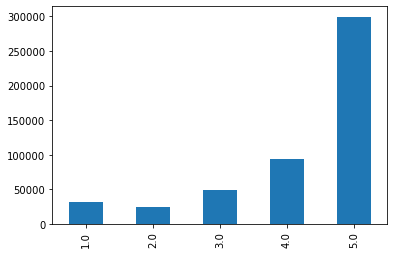

In [6]:
df['overall'].value_counts().sort_index().plot(kind="bar")

In [8]:
X = df['reviewText']
y = df['overall']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

In [9]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


ModuleNotFoundError: No module named 'transformers'